In [107]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


# Table of Content
1. Some EDA
2. Build model from pre-trained Transformer from Tensorflow hub
3. Train the model
4. Prediction and submission

# TODO
1. Add text preprocessing
2. Try build Transformer from ground up and compare result



#### Vanilla pre-trained transformer score: 0.7634

In [108]:
test_data = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')
train_data = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
train_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
train_data.info()

In [ ]:
train_data.location[100] # See what is a typical location value

In [ ]:
train_data.keyword[100] # See what is a typical keyword value

In [ ]:
train_data.text[100] # See what is a typical text value

In [ ]:
train_data.text[99] # See another text value to compare length

In [ ]:
train_data.head()

# Data preprocessing
Concat keyword and location to the end of text

In [109]:
import re
import nltk
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
import zipfile
import tempfile
import string
from PIL import Image #, ImageDraw, ImageFont
#from PIL import ImageOps
nltk.download('wordnet')
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Archive:  /usr/share/nltk_data/corpora/wordnet.zip
replace /usr/share/nltk_data/corpora/wordnet/lexnames? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [ ]:
train_data = train_data.fillna('')

In [ ]:
train_data.head()

In [112]:
def clean_text(text):
    text=str(text).lower() #Converts text to lowercase
    text=re.sub('\d+', '', text) #removes numbers
    text=re.sub('\[.*?\]', '', text) #removes HTML tags
    text=re.sub('https?://\S+|www\.\S+', '', text) #removes url
    text=re.sub(r"["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", "", text) #removes emojis
    text=re.sub('[%s]' % re.escape(string.punctuation),'',text) #removes punctuations
    #text = re.sub('\n', '', text)
    #text = re.sub('\w*\d\w*', '', text)
    return text

In [ ]:
train_data.head()

In [ ]:
train_data['text']=train_data['text'].apply(clean_text)
train_data.head()

In [113]:
stop=set(stopwords.words('english'))

In [ ]:
train_data['text'] = train_data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
train_data.head()

In [114]:
lemma=WordNetLemmatizer()

def preprocessdata(text):
    text= ' '.join(lemma.lemmatize(word) for word in text.split(' '))
    return text

train_data['text']=train_data['text'].apply(preprocessdata)
train_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All resident asked to 'shelter in place' are b...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska a s...,1


In [ ]:
spaces = [' ' for i in range(0, len(train_data.location))]
X = train_data.text + spaces + train_data.location + spaces + train_data.keyword
# X = [[x] for x in X]

In [ ]:
X[100]

In [ ]:
y = train_data.target
train_data = pd.concat([pd.Series(X, name = 'text'), y], axis = 1)
train_data.head(2)

# Building the model using pre-trained model
Transformer: reference https://blog.paperspace.com/transformers-text-classification/

In [115]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, Dropout, Layer
from tensorflow.keras.layers import Embedding, Input, GlobalAveragePooling1D, Dense
from tensorflow.keras.models import Sequential, Model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=42)

In [ ]:
train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train))
validation_data = tf.data.Dataset.from_tensor_slices((X_val, y_val))

In [ ]:
train_data

In [ ]:
train_examples_batch, train_labels_batch = next(iter(train_data.batch(10)))
train_examples_batch[:1]

In [ ]:
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(embedding, input_shape=[], 
                           dtype=tf.string, trainable=True)
                           
print(hub_layer(train_examples_batch[:3]))

In [ ]:
model = Sequential()
model.add(hub_layer)
model.add(Dense(20, activation='relu'))
model.add(Dense(1))

model.summary()

# Train the model

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
              
history = model.fit(train_data.shuffle(10000).batch(512),
                    epochs=10,
                    validation_data=validation_data.batch(512),
                    verbose=1)

# Evaluate on test data

In [ ]:
test_data = test_data.fillna('')
test_data['text']=test_data['text'].apply(clean_text)
test_data['text'] = test_data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
test_data['text']=test_data['text'].apply(preprocessdata)

spaces = [' ' for i in range(0, len(test_data.location))]
X_test = test_data.text + spaces + test_data.location + spaces + test_data.keyword

In [ ]:
X_test[1]

In [ ]:
test_data = tf.data.Dataset.from_tensor_slices(X_test)

In [ ]:
test_data

In [ ]:
results = model.evaluate(test_data.batch(10), verbose=2)

for name, value in zip(model.metrics_names, results):
    print("%s: %.3f" % (name, value))

In [ ]:
test_data

In [ ]:
submissions = model.predict(test_data.batch(1))

In [ ]:
submissions = [y[0] for y in submissions]

In [ ]:
pred = tf.round(tf.nn.sigmoid(submissions))

In [ ]:
pred[:10]

In [ ]:
test_data = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')

In [ ]:
data = {'id': test_data.id, 'target': pred.numpy().astype(int)}
submissions = pd.DataFrame(data)
submissions.to_csv('submissions.csv', index=False)

In [ ]:
submissions.head()

# Build Your Own Transformer Model

In [116]:
class TransformerBlock(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.5):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.dropout1 = Dropout(rate)
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.ffn = Sequential(
            [Dense(ff_dim, activation="relu"), 
             Dense(embed_dim),]
        )
        self.dropout2 = Dropout(rate)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [117]:
class TokenAndPositionEmbedding(Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

# Redo Preprocessing

In [118]:
vocab_size = 17000  # Only consider the top 17k words
maxlen = 16  # Only consider the first 23 words of each tweet

In [119]:
train_data = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')

train_data = train_data.fillna('')
train_data['text']=train_data['text'].apply(clean_text)
train_data['text'] = train_data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
train_data['text']=train_data['text'].apply(preprocessdata)

spaces = [' ' for i in range(0, len(train_data.location))]
X = train_data.text + spaces + train_data.location + spaces + train_data.keyword

In [120]:
# Get the most frequent words
frequent_words = pd.Series(' '.join(X).split()).value_counts()[:vocab_size]
vocabulary = frequent_words.keys().tolist()
def map2vocab_index(text):
    word_indices = np.asarray([vocabulary.index(word) for word in text.split() if word in vocabulary]).astype('float32')
    return word_indices

X = X.apply(map2vocab_index)
y = np.asarray(train_data.target)

In [104]:
length = [len(x) for x in X]
pd.Series(length).describe()

count    7613.000000
mean       11.196769
std         3.854303
min         1.000000
25%         8.000000
50%        11.000000
75%        14.000000
max        27.000000
dtype: float64

In [105]:
pd.Series(length).quantile(0.9)

16.0

In [ ]:
len(vocabulary)

In [ ]:
X[:2]

In [121]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=42)

X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, maxlen=maxlen)
X_val = tf.keras.preprocessing.sequence.pad_sequences(X_val, maxlen=maxlen)

# Developing the Model

In [129]:
embed_dim = 64  # Embedding size for each token
num_heads = 4  # Number of attention heads
ff_dim = 256  # Hidden layer size in feed forward network inside transformer

def get_model():
    inputs = Input(shape=(maxlen,))
    embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
    x = embedding_layer(inputs)
    transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim, rate = 0.1)
    x = transformer_block(x)
    # transformer_block2 = TransformerBlock(embed_dim, num_heads, ff_dim, rate = 0.1)
    # x = transformer_block2(x)
    x = GlobalAveragePooling1D()(x)
    x = Dropout(0.5)(x)
    x = Dense(32, activation="relu")(x)
    x = Dropout(0.3)(x)
    outputs = Dense(1, activation="sigmoid")(x)

    return Model(inputs=inputs, outputs=outputs)

In [ ]:
X_val[:2]

# Compiling and Fitting the Model

StatifiedFold method adopted from this notebook: https://www.kaggle.com/code/lonnieqin/disaster-tweets-classification-transformer

In [123]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

Fold 1
Epoch 1/20
255/255 [==============================] - 6s 17ms/step - loss: 0.6869 - accuracy: 0.5642 - val_loss: 0.6713 - val_accuracy: 0.5755
Epoch 2/20
255/255 [==============================] - 4s 17ms/step - loss: 0.6595 - accuracy: 0.5990 - val_loss: 0.6434 - val_accuracy: 0.6725
Epoch 3/20
255/255 [==============================] - 4s 15ms/step - loss: 0.5641 - accuracy: 0.7164 - val_loss: 0.5264 - val_accuracy: 0.7441
Epoch 4/20
255/255 [==============================] - 4s 15ms/step - loss: 0.3935 - accuracy: 0.8400 - val_loss: 0.5466 - val_accuracy: 0.7284
Epoch 5/20
255/255 [==============================] - 4s 17ms/step - loss: 0.2661 - accuracy: 0.9047 - val_loss: 0.5821 - val_accuracy: 0.7539
Epoch 6/20
255/255 [==============================] - 4s 17ms/step - loss: 0.1792 - accuracy: 0.9365 - val_loss: 0.6841 - val_accuracy: 0.7510
Epoch 7/20
255/255 [==============================] - 4s 17ms/step - loss: 0.1281 - accuracy: 0.9583 - val_loss: 0.8024 - val_accuracy:

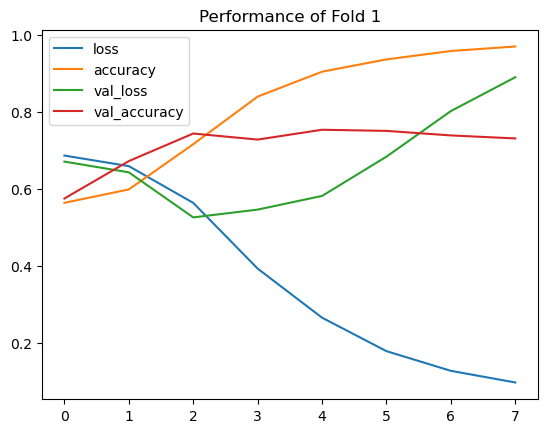

32/32 [==============================] - 0s 7ms/step


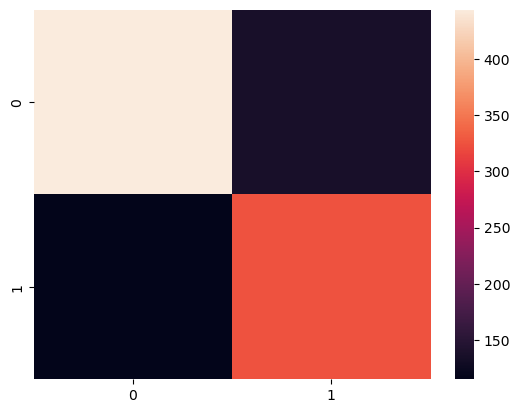

Classification Report: 

              precision    recall  f1-score   support

           0       0.79      0.77      0.78       580
           1       0.70      0.74      0.72       440

    accuracy                           0.75      1020
   macro avg       0.75      0.75      0.75      1020
weighted avg       0.76      0.75      0.75      1020

Accuracy Score: 0.75
Fold 2
Epoch 1/20
255/255 [==============================] - 6s 17ms/step - loss: 0.6931 - accuracy: 0.5625 - val_loss: 0.6644 - val_accuracy: 0.5961
Epoch 2/20
255/255 [==============================] - 4s 15ms/step - loss: 0.6353 - accuracy: 0.6402 - val_loss: 0.5871 - val_accuracy: 0.7157
Epoch 3/20
255/255 [==============================] - 4s 15ms/step - loss: 0.4997 - accuracy: 0.7600 - val_loss: 0.5114 - val_accuracy: 0.7471
Epoch 4/20
255/255 [==============================] - 4s 15ms/step - loss: 0.3567 - accuracy: 0.8625 - val_loss: 0.5146 - val_accuracy: 0.7814
Epoch 5/20
255/255 [============================

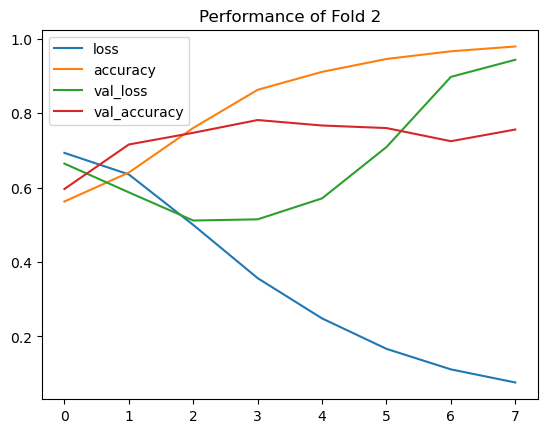

32/32 [==============================] - 0s 6ms/step


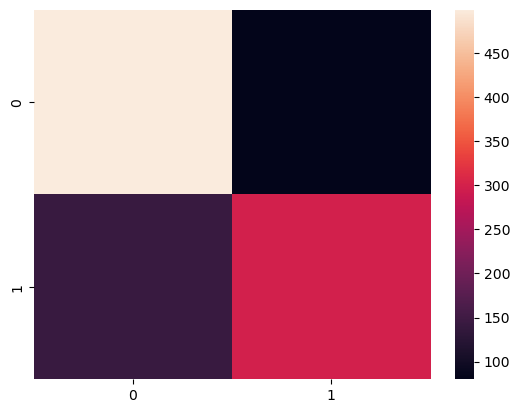

Classification Report: 

              precision    recall  f1-score   support

           0       0.78      0.86      0.82       579
           1       0.79      0.68      0.73       441

    accuracy                           0.78      1020
   macro avg       0.78      0.77      0.77      1020
weighted avg       0.78      0.78      0.78      1020

Accuracy Score: 0.78
Fold 3
Epoch 1/20
255/255 [==============================] - 6s 16ms/step - loss: 0.6921 - accuracy: 0.5544 - val_loss: 0.6631 - val_accuracy: 0.5794
Epoch 2/20
255/255 [==============================] - 4s 15ms/step - loss: 0.6650 - accuracy: 0.5904 - val_loss: 0.6278 - val_accuracy: 0.6735
Epoch 3/20
255/255 [==============================] - 4s 16ms/step - loss: 0.5707 - accuracy: 0.7113 - val_loss: 0.5174 - val_accuracy: 0.7520
Epoch 4/20
255/255 [==============================] - 4s 15ms/step - loss: 0.3952 - accuracy: 0.8333 - val_loss: 0.5447 - val_accuracy: 0.7480
Epoch 5/20
255/255 [============================

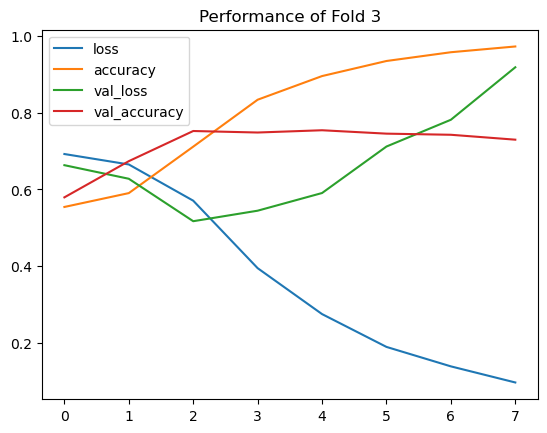

32/32 [==============================] - 0s 7ms/step


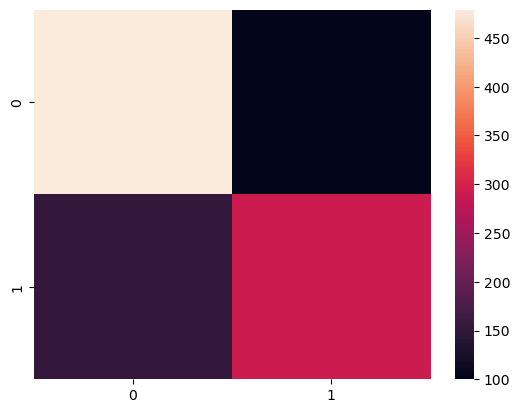

Classification Report: 

              precision    recall  f1-score   support

           0       0.76      0.83      0.79       579
           1       0.74      0.66      0.70       441

    accuracy                           0.75      1020
   macro avg       0.75      0.74      0.75      1020
weighted avg       0.75      0.75      0.75      1020

Accuracy Score: 0.75
Fold 4
Epoch 1/20
255/255 [==============================] - 6s 17ms/step - loss: 0.6967 - accuracy: 0.5390 - val_loss: 0.6622 - val_accuracy: 0.5873
Epoch 2/20
255/255 [==============================] - 4s 15ms/step - loss: 0.6562 - accuracy: 0.6074 - val_loss: 0.6240 - val_accuracy: 0.6490
Epoch 3/20
255/255 [==============================] - 4s 15ms/step - loss: 0.5726 - accuracy: 0.7093 - val_loss: 0.4993 - val_accuracy: 0.7755
Epoch 4/20
255/255 [==============================] - 4s 15ms/step - loss: 0.3885 - accuracy: 0.8404 - val_loss: 0.5239 - val_accuracy: 0.7833
Epoch 5/20
255/255 [============================

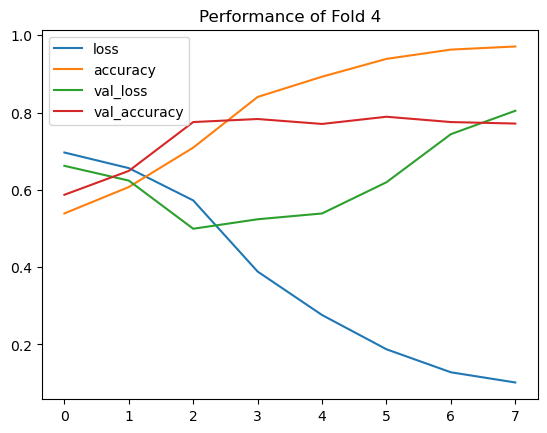

32/32 [==============================] - 0s 7ms/step


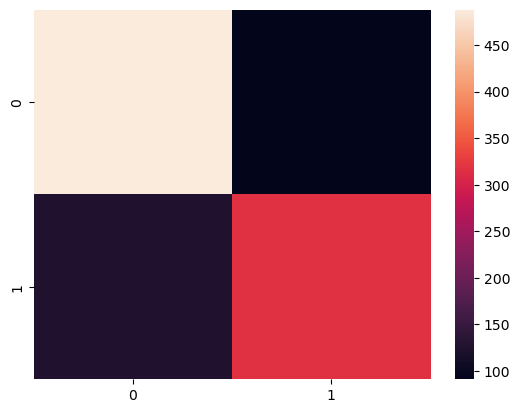

Classification Report: 

              precision    recall  f1-score   support

           0       0.80      0.84      0.82       579
           1       0.78      0.72      0.75       441

    accuracy                           0.79      1020
   macro avg       0.79      0.78      0.78      1020
weighted avg       0.79      0.79      0.79      1020

Accuracy Score: 0.79
Fold 5
Epoch 1/20
255/255 [==============================] - 6s 17ms/step - loss: 0.6900 - accuracy: 0.5640 - val_loss: 0.6600 - val_accuracy: 0.6353
Epoch 2/20
255/255 [==============================] - 4s 16ms/step - loss: 0.6441 - accuracy: 0.6301 - val_loss: 0.5948 - val_accuracy: 0.7255
Epoch 3/20
255/255 [==============================] - 4s 15ms/step - loss: 0.5135 - accuracy: 0.7554 - val_loss: 0.5093 - val_accuracy: 0.7676
Epoch 4/20
255/255 [==============================] - 4s 15ms/step - loss: 0.3664 - accuracy: 0.8449 - val_loss: 0.5288 - val_accuracy: 0.7814
Epoch 5/20
255/255 [============================

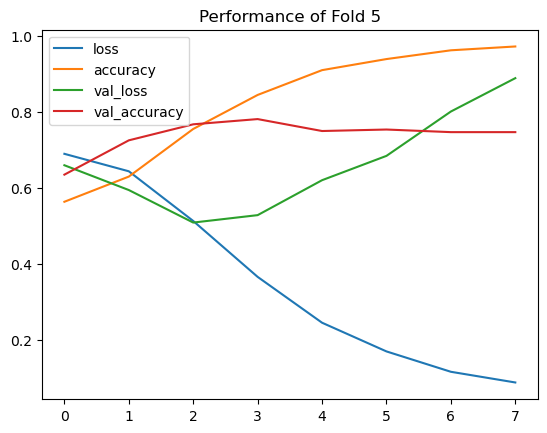

32/32 [==============================] - 0s 7ms/step


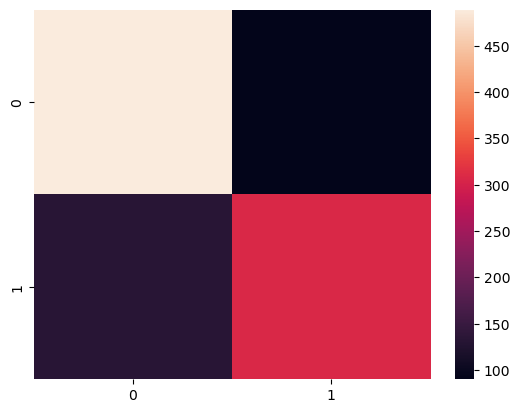

Classification Report: 

              precision    recall  f1-score   support

           0       0.79      0.84      0.81       579
           1       0.77      0.70      0.73       441

    accuracy                           0.78      1020
   macro avg       0.78      0.77      0.77      1020
weighted avg       0.78      0.78      0.78      1020

Accuracy Score: 0.78


In [130]:
index = 1
models = []
tf.keras.backend.clear_session()

for train_indices, val_indices in StratifiedKFold(5, shuffle=True, random_state=42).split(X_train, y_train):
    print("Fold %d" %(index))
    train_features, train_targets = X_train[train_indices], y_train[train_indices]
    validation_features, validation_targets = X_train[val_indices], y_train[val_indices]
    model_checkpoint_path = "model%d.h5"%(index)
    
    model = get_model()
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), 
                    loss=tf.keras.losses.BinaryCrossentropy(), metrics=["accuracy"])
    
    early_stop = tf.keras.callbacks.EarlyStopping(patience=5)
    recuce_Lr = tf.keras.callbacks.ReduceLROnPlateau(patience=2)
    model_checkpoint = tf.keras.callbacks.ModelCheckpoint(model_checkpoint_path, monitor="val_accuracy", save_best_only=True, save_weights_only=True)
    
    history = model.fit(train_features, train_targets, validation_data=(validation_features, validation_targets), batch_size=16, epochs=20, callbacks=[early_stop, model_checkpoint])
    pd.DataFrame(history.history).plot(kind="line")
    plt.title("Performance of Fold %d"%(index))
    plt.show()
    model.load_weights(model_checkpoint_path)
    y_val_pred = np.array(model.predict(validation_features) > 0.5, dtype="int").reshape(-1)
    cm = confusion_matrix(validation_targets, y_val_pred)
    sns.heatmap(cm)
    plt.show()
    print("Classification Report: \n")
    print(classification_report(validation_targets, y_val_pred))
    acc_score = accuracy_score(validation_targets, y_val_pred)
    print("Accuracy Score: %.2f"%(acc_score))
    models.append(model)
    index += 1

In [138]:
get_model().summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 16)]              0         
                                                                 
 token_and_position_embeddin  (None, 16, 64)           1089024   
 g_5 (TokenAndPositionEmbedd                                     
 ing)                                                            
                                                                 
 transformer_block_5 (Transf  (None, 16, 64)           99712     
 ormerBlock)                                                     
                                                                 
 global_average_pooling1d_5   (None, 64)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dropout_22 (Dropout)        (None, 64)                0   

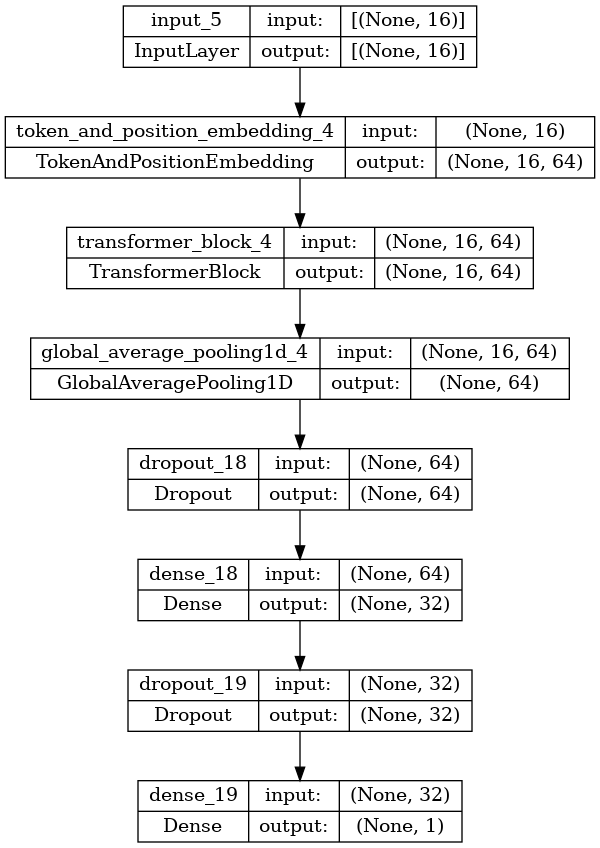

In [139]:
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.save("predict_class.h5")

# Evaluating the Model

In [132]:
results = model.evaluate(X_val, y_val, verbose=2)

for name, value in zip(model.metrics_names, results):
    print("%s: %.3f" % (name, value))

79/79 - 1s - loss: 0.5278 - accuracy: 0.7716 - 521ms/epoch - 7ms/step
loss: 0.528
accuracy: 0.772


# Predicting with Handmade Model

In [133]:
test_data = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')

test_data = test_data.fillna('')
test_data['text']=test_data['text'].apply(clean_text)
test_data['text'] = test_data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
test_data['text']=test_data['text'].apply(preprocessdata)


spaces = [' ' for i in range(0, len(test_data.location))]
X_test = test_data.text + spaces + test_data.location + spaces + test_data.keyword

X_test = X_test.apply(map2vocab_index)

In [134]:
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, maxlen=maxlen)

In [135]:
X_test = np.asarray([np.asarray(x).astype('float32') for x in X_test])

In [ ]:
X_test.dtype

In [ ]:
# model = keras.models.load_model('/kaggle/working/predict_class.h5')

In [142]:
y_test = np.mean([model.predict(X_test).reshape(-1) for model in models], axis=0)
y_test = np.array(y_test > 0.5, dtype=int)

102/102 [==============================] - 1s 5ms/step


In [144]:
submission2 = pd.DataFrame({"id": test_data["id"], "target": y_test})
submission2.to_csv("submission2.csv", index=False)

In [146]:
submission2[:10]

,id,target
0,0,0
1,2,0
2,3,1
3,9,1
4,11,1
5,12,0
6,21,0
7,22,0
8,27,0
9,29,0


In [ ]:
X_val.dtype

In [ ]:
submissions2 = [round(entry[0]) for entry in submissions2]

In [ ]:
submissions2[:10]

In [ ]:
data = {'id': test_data.id, 'target': submissions2}
submissions2 = pd.DataFrame(data)
submissions2.to_csv('submissions2.csv', index=False)

In [ ]:
submissions2.head(2)

In [ ]:
submissions2.to_csv('submissions2.csv', index=False)